In [6]:
metadata = initialize_VAE(encoder_path, yaml_config, training=True)

In [7]:
args = Args(
    data_train = datasets['train'],
    data_val = datasets['val'],
    data_test = datasets['test'],
    data_config = yaml_config,
    num_epochs = 3,
    batch_size = 128,
    model_prefix = 'models/torch_saved/DSVAE',
    file_fraction = 1,
    data_fraction = 0.1
)

In [8]:
train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(args)

In [24]:
data_config.input_shapes['pf_features'][-1]

32

In [9]:
model = copy.deepcopy(metadata['model']).to(device)
loss_func = metadata['loss']

opt, scheduler = optim(args, model, device)

In [10]:
train_size = (1e+08 * (num_classes / 10)) * args.data_fraction
val_size = (5e+06 * (num_classes / 10)) * args.data_fraction
test_size = (2e+07 * (num_classes / 10)) * args.data_fraction

In [11]:
steps_per_epoch = int(train_size / args.batch_size)

annealer = Annealer(steps_per_epoch, shape='cosine', cyclical=True)

In [12]:
all_inputs = []
all_outputs = []
all_latents = []

In [14]:
tb = None

# training loop
best_valid_metric = np.inf if args.regression_mode else 0
grad_scaler = torch.amp.GradScaler("cuda")
for epoch in range(args.num_epochs):
    if args.load_epoch is not None:
        if epoch <= args.load_epoch:
            continue
    _logger.info('-' * 50)
    _logger.info('Epoch #%d training' % epoch)
    train_autoencoder(model, opt, scheduler, train_loader, device, epoch, train_size, alpha=0, beta=0, gamma=0,
          steps_per_epoch=args.steps_per_epoch, grad_scaler=grad_scaler, tb_helper=tb, annealer=annealer)
    if args.model_prefix and (args.backend is None or local_rank == 0):
        dirname = os.path.dirname(args.model_prefix)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        state_dict = model.module.state_dict() if isinstance(
            model, (torch.nn.DataParallel, torch.nn.parallel.DistributedDataParallel)) else model.state_dict()
        torch.save(state_dict, args.model_prefix + '_epoch-%d_state.pt' % epoch)
        torch.save(opt.state_dict(), args.model_prefix + '_epoch-%d_optimizer.pt' % epoch)

    inputs, outputs, latents, labels = evaluate_autoencoder(model, val_loader, device, epoch, val_size, 
                                                    alpha=1.0, beta=4.0, gamma=1.0, 
                                                    steps_per_epoch=args.steps_per_epoch_val, tb_helper=tb)
    all_inputs.append(inputs)
    all_outputs.append(outputs)
    all_latents.append(latents)

0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


343it [02:10,  2.64it/s, lr=1.00e-03, Loss=3.14739, AvgLoss=3.40450, MIL=14.50866, TCL=22.49020, DWKL=34.53259, Reconstruction Loss=3.14739, Beta=0.00]


KeyboardInterrupt: 

In [28]:
test_latents = torch.cat(all_latents[0]).detach().cpu().numpy()

In [38]:
test_inputs = torch.cat(all_inputs[4]).detach().cpu().numpy()
test_outputs = torch.cat(all_outputs[4]).detach().cpu().numpy()

In [29]:
test_latents[:, 0]

array([-0.00438514, -0.00232265, -0.00458759, ...,  0.00312938,
       -0.04390197, -0.00591927], dtype=float32)

In [30]:
variances = []

for i in range(len(test_latents[0])):
    variances.append(np.var(test_latents[:, i]))

In [31]:
variances

[4.107772e-05,
 5.8643473e-05,
 2.7304919e-05,
 2.4147586e-05,
 9.147498e-05,
 2.9693572e-05,
 5.7909292e-05,
 1.9201858e-05,
 4.9824695e-05,
 6.489301e-05,
 2.9110153e-05,
 5.5547596e-05,
 2.9641265e-05,
 4.036641e-05,
 2.106113e-05,
 3.419464e-05,
 7.957268e-05,
 4.0553277e-05,
 1.9548057e-05,
 3.6478752e-05,
 2.9421664e-05,
 4.2069794e-05,
 4.8810612e-05,
 3.9501123e-05,
 8.279432e-05,
 4.197146e-05,
 1.1112967e-05,
 5.8592523e-05,
 4.9326514e-05,
 2.9992805e-05,
 4.9526116e-05,
 6.704566e-05]

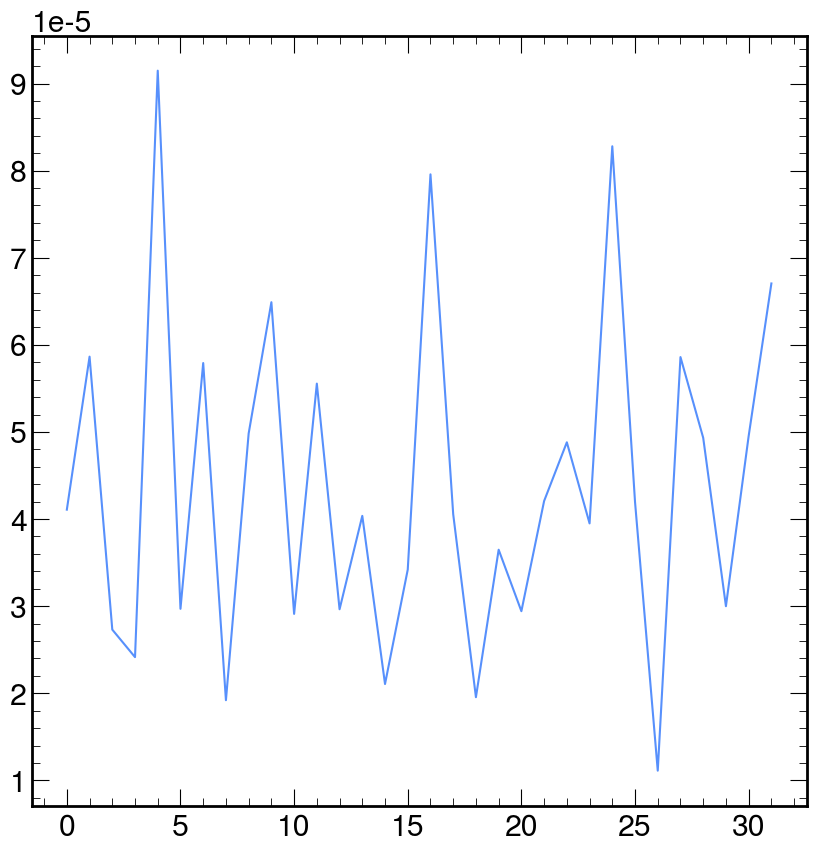

In [32]:
plt.plot(variances)

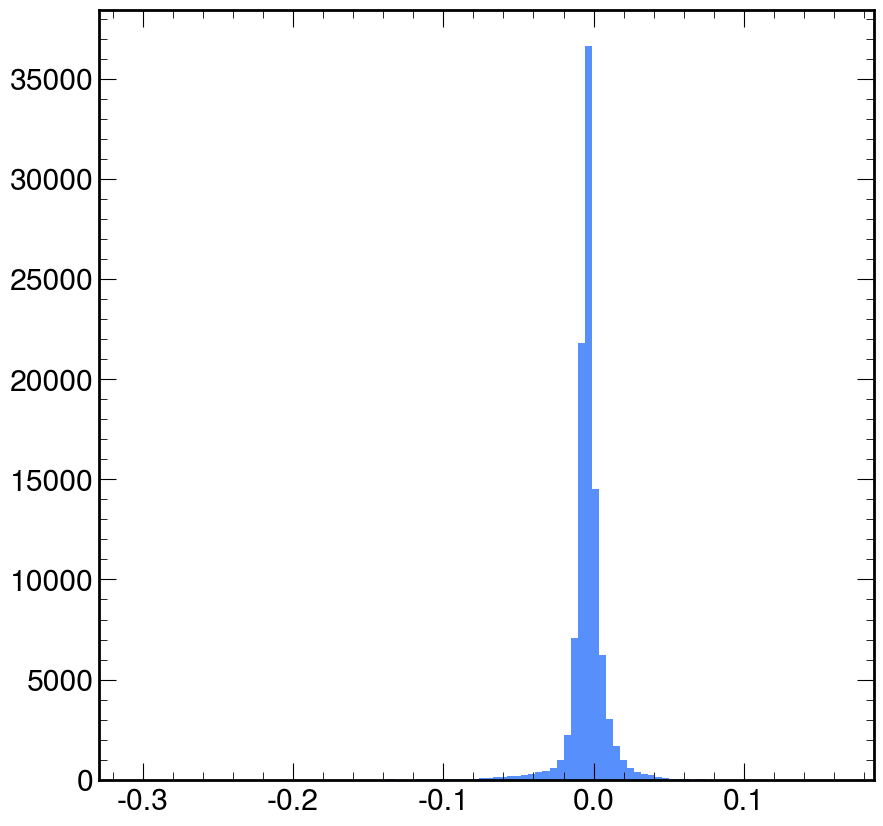

In [37]:
plt.hist(test_latents[:, 21], bins=100)
plt.show()

In [39]:
jet_1 = test_inputs[1]

In [40]:
deta = jet_1[5].flatten()
dphi = jet_1[6].flatten()

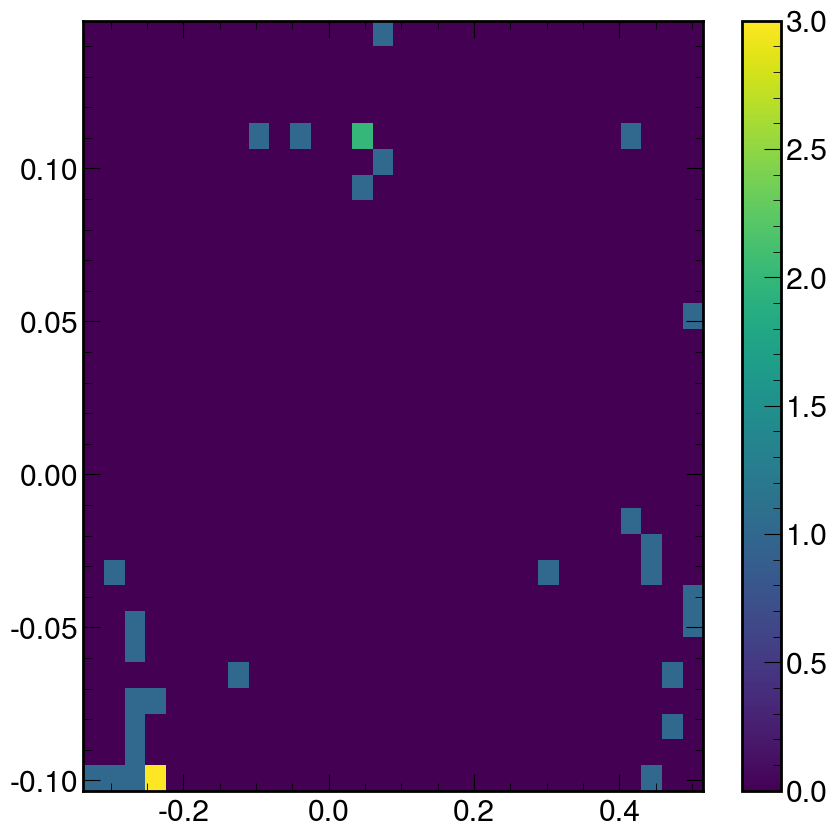

In [43]:
plt.hist2d(dphi, deta, bins = [30, 30])
plt.colorbar()
plt.show()

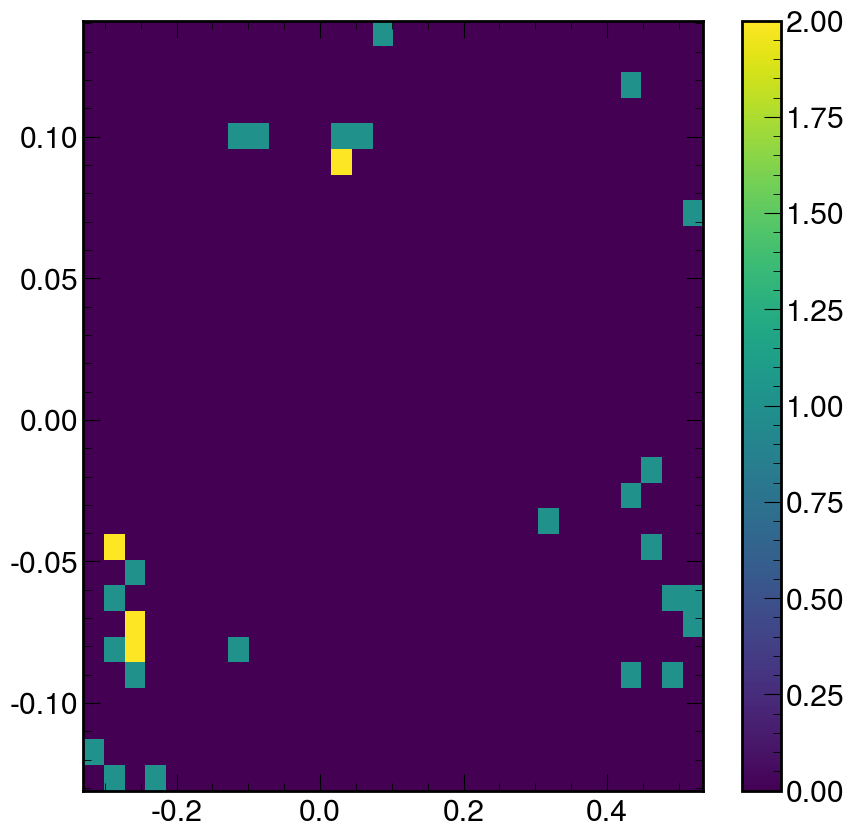

In [44]:
jet_1 = test_outputs[1]
deta = jet_1[5].flatten()
dphi = jet_1[6].flatten()

plt.hist2d(dphi, deta, bins = [30, 30])
plt.colorbar()
plt.show()

In [55]:
variances = []

for i in range (32):
    variances.append(np.var(test_latents[:, i]))

In [56]:
variances

[0.00013913753,
 0.00019380986,
 0.000109969646,
 8.856737e-05,
 0.00029868493,
 3.9499566e-05,
 0.00014035596,
 0.00018182791,
 5.9939073e-05,
 3.7997183e-05,
 0.00010013836,
 0.00011136502,
 0.00012876157,
 6.1807754e-05,
 1.7776045e-05,
 0.00010679657,
 0.00056260894,
 0.00024398025,
 0.0003688456,
 7.053085e-05,
 0.00010315225,
 0.00023405219,
 6.791583e-05,
 0.00018068505,
 0.00045805352,
 0.00040020523,
 3.747955e-05,
 0.00030714975,
 0.00041701653,
 0.00016778671,
 0.00043396905,
 0.00077541947]

In [43]:
np.sum(variances)

0.0066452846

In [31]:
test_latents[:, 0]

array([ 0.00459811, -0.00841095,  0.00446302, ...,  0.00506005,
        0.01154377, -0.00851087], dtype=float32)

In [18]:
metadata = initialize_CNN(network_path, yaml_config, training=False, model_path = 'models/torch_saved/ResNet_epoch-4_state.pt')

In [8]:
data_config = SimpleIterDataset({}, yaml_config, for_training=True).config

dataset = read_file(datasets['train'][0], max_num_particles=32, particle_features=data_config.input_dicts['pf_features'])

In [9]:
from src.metrics.robustness import augment_with_boost_general

In [ ]:
torch.transpose(augment_with_boost_general(torch.transpose(torch.Tensor(dataset[1]), -2, -1), beta_max=0.5), -2, -1)

In [11]:
class Diagnostic(torch.nn.Module):
    def __init__(
        self,
        encoder,
        num_classes,
        latent_dims = (128, 128, 128),
        input_dims = 16
    ):
        super(Diagnostic, self).__init__()

        self.encoder = encoder
        fc_layers = []
        for i in range(len(latent_dims)):
            fc_layers.append(nn.Sequential(
                nn.Linear(input_dims if i == 0 else latent_dims[i - 1], latent_dims[i]),
                nn.ReLU())
            )
        fc_layers.append(nn.Linear(latent_dims[-1], num_classes))
        self.fc = nn.Sequential(*fc_layers)

    def forward(self, points, features, lorentz_vectors, mask):

        mean, log_var = self.encoder(points, features, lorentz_vectors, mask)

        return self.fc(torch.cat([mean, log_var], axis=1))

In [9]:
cnn_metadata = initialize_CNN(network_path, yaml_config, training=False, model_path = 'models/torch_saved/student_models/ResNet_student_1_3_epoch-4_state.pt')
teacher = copy.deepcopy(cnn_metadata['model']).to(device)

encoder_metadata = initialize_VAE(encoder_path, yaml_config, training=False, model_path = 'models/torch_saved/DSVAE_epoch-4_state.pt')
encoder = copy.deepcopy(encoder_metadata['model']).to(device)

#loss_func = torch.nn.MSELoss()

In [13]:
args = Args(
    data_train = datasets['train'],
    data_val = datasets['val'],
    data_test = datasets['test'],
    data_config = yaml_config,
    num_epochs = 1,
    batch_size = 64,
    model_prefix = 'models/torch_saved/student_models/DSEncoder_DIAGNOSTIC',
    file_fraction = 1,
    data_fraction = 0.01
)

train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(args)

opt, scheduler = optim(args, model, device)

In [17]:
student = Diagnostic(encoder, 2).to(device)

student.encoder.requires_grad = False

In [16]:
outputs['pre_forward_hooks']['inputs'] = []

pairwise_hook = model.mod.register_forward_pre_hook(HookHandler.save_inputs('inputs', outputs['pre_forward_hooks']))

In [8]:
pred_args = Args(
    data_test = datasets['train'],
    data_config = yaml_config,
    batch_size = 64,
    file_fraction = 1,
    data_fraction = 0.001
)

test_loaders, data_config = test_load(pred_args)

for name, get_test_loader in test_loaders.items():
    
    test_loader = get_test_loader()
    
    outputs, logits = evaluate_autoencoder(model, teacher, test_loader, device, epoch=None, for_training=False)
    
    del test_loader

0it [00:00, ?it/s]

=== Restarting DataIter test_, seed=None ===


313it [00:41,  7.58it/s, Loss=0.33178, AvgLoss=0.00000]


In [18]:
logits = torch.cat(outputs['forward_hooks']['logits']).cpu().numpy()

In [19]:
inputs = outputs['pre_forward_hooks']['inputs']

In [10]:
concat_inputs = []

for v in range(4):
    if inputs[0][v] is None:
        continue
    
    concat_inputs.append(
        torch.cat(
            [inputs[i][v].cpu() for i in range(len(inputs))],
            dim=0
        ).numpy()
    )

n_samples = concat_inputs[1].shape[0]
mask_indices = np.array([i for i, arr in enumerate(concat_inputs[3]) if 0 in arr]) 
nonpadded_mask = np.ones(n_samples, dtype=bool)
nonpadded_mask[mask_indices] = False

primary_features = concat_inputs[1].reshape(n_samples, 7 * 32)[nonpadded_mask]
logits = logits

x = primary_features

NameError: name 'inputs' is not defined

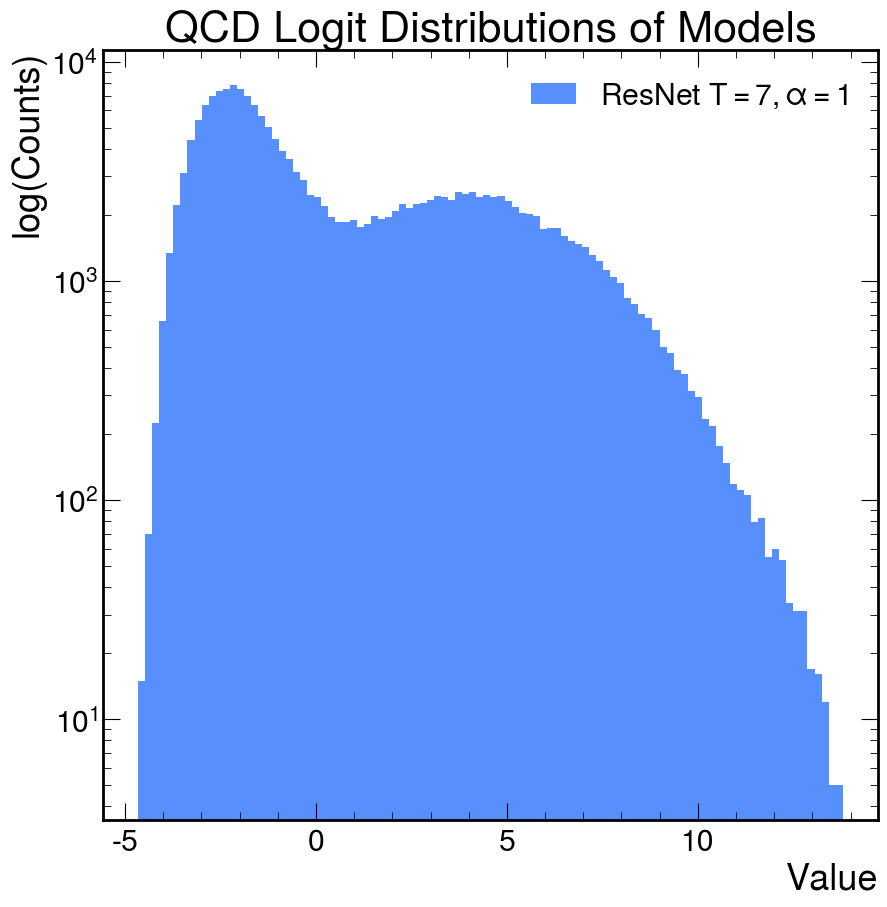

In [79]:
fig, axes = plt.subplots()

axes.set_title('QCD Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100
    
axes.hist(logits[:, 0], bins=bins, label=r'ResNet $T = 7, \alpha = 1$', alpha=1)
axes.set_yscale('log')
axes.legend()

plt.show()

In [13]:
print(model)

PySRRegressor.equations_ = [
[
	    pick         score                                           equation  \
	0         0.000000e+00                                        -0.18537588   
	1         5.903026e-08                                   sin(-0.18501629)   
	2         2.009464e-01                                   x14 * -418.92484   
	3         2.234571e-04                             tanh(x14) * -419.35892   
	4         5.244901e-02                           (x14 + x28) * -278.54477   
	5         8.558691e-02               tanh(x14 / -0.007693716) / 0.1371275   
	6         1.862230e-04         sin(tanh(x14 / 0.009295061)) / -0.11354855   
	7         2.850377e-02        tanh((x14 + x28) / -0.017028952) * 8.355983   
	8         1.965665e-02   (x20 + ((x14 * 3.5804186) + x17)) / -0.010635343   
	9         1.288721e-01  (tanh((x14 + x22) / -0.0025060982) / 0.2667662...   
	10        1.286171e-06  (tanh((sin(x22) + x14) / -0.0025060982) / 0.26...   
	11        3.792416e-02  (tanh(((

In [14]:
equations = model.sympy([13, 12])

In [16]:
equations[0]

(tanh((x3 + (x14 + x22)/0.43207005)/(-0.007451569)) + 0.5216572)/0.24945463

In [69]:
# might want to use pytorch for this one instead

import pysr
import logging
import sympy

def sympy_softmax(expr_list):
    from sympy import exp

    normalized = [exp(z) for z in expr_list]
    
    total_count = sum(normalized)
    soft_probs = [(i / total_count) for i in normalized]

    return soft_probs

def grad_study(eq_list):
    '''
    Perform a Gradient-based Proportionality Analysis on a PySR SymPy Equation List
    Must be of length 2 with the format: [background, signal]
    Evaluated on a given set of input data
    '''

    import matplotlib.pyplot as plt
    import mplhep as mh
    plt.style.use(mh.style.CMS)
    
    soft_probs = sympy_softmax(eq_list)

    preliminary_list = []

    for index, eq in enumerate(soft_probs):
        logging.info(f'Commencing Gradient Analysis for Expression {index}')
        symbols = eq.free_symbols
        logging.info(f'Expression has {len(symbols)} symbols')

        for sym in symbols:
            logging.info(f'Currently on {sym}')
            diff = sympy.diff(eq, sym)
            preliminary_list.append(diff)

    return preliminary_list

In [70]:
prelist = grad_study(equations)

In [76]:
from IPython.display import display

display(prelist[0])

-(38.4130437277232*tanh((x1 + x2*x2*(-117.73832) - (-x29/(-10.784041) + x31))*71.25216)**2 - 38.4130437277232)*exp((tanh((x1 + x2*x2*(-117.73832) - (-x29/(-10.784041) + x31))*71.25216) + tanh(-x6/(-0.059112012) + (x13 + x19 + x23)/0.20561393) - 0.107075356)*5.8138285)*exp(x6*(-79.70796) - (-295.29465*x2 + tanh(x13/x2) + 0.2890335)*tanh(0.0110762315/x2)/0.5601893)/(exp((tanh((x1 + x2*x2*(-117.73832) - (-x29/(-10.784041) + x31))*71.25216) + tanh(-x6/(-0.059112012) + (x13 + x19 + x23)/0.20561393) - 0.107075356)*5.8138285) + exp(x6*(-79.70796) - (-295.29465*x2 + tanh(x13/x2) + 0.2890335)*tanh(0.0110762315/x2)/0.5601893))**2

In [17]:
hook_manager = {
    'forward_hooks': {},
    'pre_forward_hooks': {}
}

handles, outputs = HookHandler(predictor, hook_manager).registration(safety_remove = True)

outputs['forward_hooks']['logits'] = []

pairwise_hook = predictor.mod.register_forward_hook(HookHandler.save_outputs('logits', outputs['forward_hooks']))


Removing all hooks within the model


In [17]:
pred_args = Args(
    data_test = datasets['test'],
    data_config = yaml_config,
    batch_size = 64,
    file_fraction = 1,
    data_fraction = 0.01
)

test_loaders, data_config = test_load(pred_args)

for name, get_test_loader in test_loaders.items():
    
    test_loader = get_test_loader()
    
    test_metric, scores, labels, observers = evaluate_classification(predictor, test_loader, device, epoch=None, for_training=False)
    
    del test_loader

0it [00:00, ?it/s]

=== Restarting DataIter test_, seed=None ===


625it [00:44, 14.12it/s, Loss=0.00000, AvgLoss=0.00000, Acc=0.62500, AvgAcc=0.77753]
y should be a 1d array, got an array of shape (40000, 2) instead.


In [19]:
from src.metrics.classification import confusion_matrices

In [20]:
confusion_matrices(labels['_label_'], scores)

array([[13279,  6721],
       [ 2178, 17822]])

In [18]:
from src.metrics.classification import roc_metrics

fpr, tpr, auc = roc_metrics(labels['_label_'], scores)

print(auc)

0.802772075


In [53]:
from src.metrics.complexity import total_params

In [51]:
total_params(predictor)[0] - total_params(encoder.mod.decoder)[0]

142539

In [92]:
from src.metrics.classification import bkg_rej

bkg_rej(labels['_label_'], scores)

Background Rejection at 50.0% Signal Efficiency: 194.17475728155338


194.17475728155338

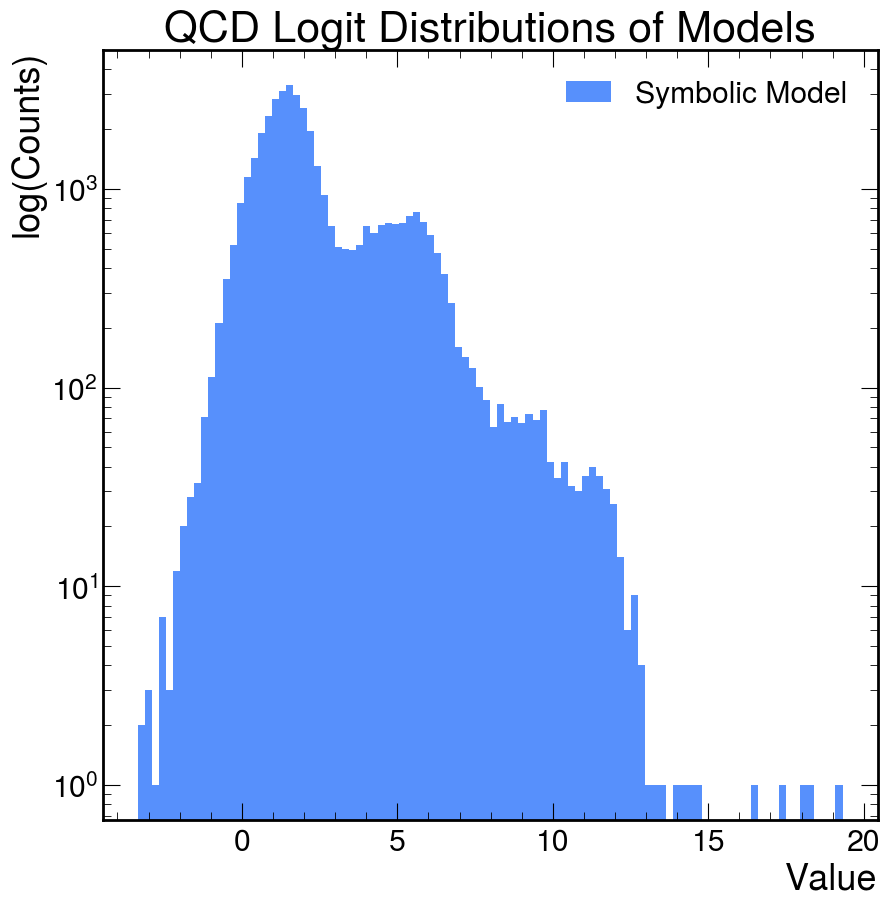

In [87]:
logits = torch.cat(outputs['forward_hooks']['logits']).cpu().numpy()

fig, axes = plt.subplots()

axes.set_title('QCD Logit Distributions of Models')
axes.set_xlabel('Value')
axes.set_ylabel('log(Counts)')
bins = 100
    
axes.hist(np.max(logits, axis=1), bins=bins, label=r'Symbolic Model', alpha=1)
axes.set_yscale('log')
axes.legend()

plt.show()

In [15]:
%load_ext autoreload
%autoreload 2

In [2]:
import pysr
from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [1]:
import sys
import os

from pathlib import Path
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
#import uproot
#import awkward as ak
import copy
import shutil

#import vector

from weaver.utils.import_tools import import_module
from src.preprocessing.datasets import SimpleIterDataset
from weaver.utils.nn.tools import evaluate_classification, train_classification
from weaver.utils.logger import _logger, warn_n_times

from src.part_prediction import test_load, train_load, knowledge_distillation, optim, train_autoencoder, evaluate_autoencoder, Annealer, final_run, evaluate_surrogates
from src.handlers.hook_handler import HookHandler

from src.metrics import *

import mplhep as mh

plt.style.use(mh.style.CMS)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_datasets = os.getenv("PART_DATA")

In [3]:
class Args:
    def __init__(self, **kwargs):
        # defaults
        self.data_train = []
        self.data_test = []
        self.data_val = []
        self.num_workers = 0
        self.num_epochs = 0
        self.data_config = ''
        self.extra_selection = None
        self.extra_test_selection = None
        self.file_fraction = 1
        self.data_fraction = 1
        self.fetch_by_files = False
        self.fetch_step = 0.01
        self.batch_size = 0
        self.in_memory = False
        self.local_rank = None
        self.copy_inputs = False
        self.demo = False
        self.no_remake_weights = False
        self.steps_per_epoch = None
        self.steps_per_epoch_val = None
        self.backend = None
        self.model_prefix = None
        self.lr_finder = None
        self.optimizer_option = []
        self.optimizer = 'ranger'
        self.start_lr = 1e-3
        self.final_lr = 1e-6
        self.lr_scheduler = 'flat+decay'
        self.load_epoch = None
        self.gpus = 0
        self.predict_gpus = 0
        self.regression_mode = False
        self.kl_weight = 0.1
        self.class_weight = 1.0
        
        for key, value in kwargs.items():
            setattr(self, key, value)

In [4]:
yaml_config = 'data_config/JetClass/JetClass_kin.yaml'
teacher_path = 'models/networks/pelican_wrapper.py'
network_path = 'models/networks/part_wrapper.py'
encoder_path = 'models/networks/autoencoder.py'

jc_paths = {
    'train': path_datasets+'/JetClass/Pythia/train_100M',
    'val': path_datasets+'/JetClass/Pythia/val_5M',
    'test': path_datasets+'/JetClass/Pythia/test_20M'
}

num_classes = 2
signal = '/TTBar_*.root'
background = '/ZJetsToNuNu_*.root'

datasets = {}

for name, path in jc_paths.items():

    if isinstance(signal, str):
        signal_files = glob.glob(path+signal)

    if isinstance(background, str):
        background_files = glob.glob(path+background)

    datasets[name] = signal_files + background_files

complexity = {
    'particle_attn': 2,
    'class_attn': 1
}

In [5]:
def initialize_CNN(network_path, config_path, training = True, model_path = None) -> dict:

    models = {}
    
    network_module = import_module(network_path, name='_network_module')
    data_config = SimpleIterDataset({}, config_path, for_training=training).config
    model, model_info = network_module.get_model(data_config)

    if model_path is not None:
        wts = torch.load(model_path, map_location = 'cpu', weights_only = True)
        model.load_state_dict(wts)
    
    model_metadata = {
        'model': model,
        'info': model_info,
        'loss': network_module.get_loss(data_config)
    }

    return model_metadata

def initialize_PELICAN(network_path, config_path, training = True, model_path = None) -> dict:

    models = {}
    
    network_module = import_module(network_path, name='_network_module')
    data_config = SimpleIterDataset({}, config_path, for_training=training).config
    model, model_info = network_module.get_model(data_config,
                                                 dataset='',
                                                 method='spurions',
                                                 stabilizer='so2',
                                                 average_nobj=16,
                                                 scale=0.1,
                                                 num_channels_scalar=10,
                                                 num_channels_m=[[60],]*5,
                                                 num_channels_2to2=[35,]*5,
                                                 num_channels_out=[60],
                                                 num_channels_m_out=[60, 35]
                                                )

    if model_path is not None:
        wts = torch.load(model_path, map_location = 'cpu', weights_only = True)
        model.load_state_dict(wts)
    
    model_metadata = {
        'model': model,
        'info': model_info,
        'loss': network_module.get_loss(data_config)
    }

    return model_metadata

def initialize_VAE(network_path, config_path, training = True, model_path = None) -> dict:

    models = {}
    
    network_module = import_module(network_path, name='_network_module')
    data_config = SimpleIterDataset({}, config_path, for_training=training).config
    model, model_info = network_module.get_model(data_config)

    if model_path is not None:
        wts = torch.load(model_path, map_location = 'cpu', weights_only = True)
        model.load_state_dict(wts)
    
    model_metadata = {
        'model': model,
        'info': model_info,
        'loss': network_module.get_loss(data_config)
    }

    return model_metadata

def initialize_part(network_path, config_path, training = True, model_path = None) -> dict:

    models = {}
    
    network_module = import_module(network_path, name='_network_module')
    data_config = SimpleIterDataset({}, config_path, for_training=training).config
    model, model_info = network_module.get_model(data_config, num_layers = complexity['particle_attn'], num_cls_layers = complexity['class_attn'])

    if model_path is not None:
        wts = torch.load(model_path, map_location = 'cpu', weights_only = True)
        model.load_state_dict(wts)
    
    model_metadata = {
        'model': model,
        'info': model_info,
        'loss': network_module.get_loss(data_config)
    }

    return model_metadata

In [16]:
model = PySRRegressor.from_file(run_directory ='outputs/pysr_outputs/sr_tests/20260212_080850_QrMN0z')

Attempting to load model from outputs/pysr_outputs/sr_tests/20260212_080850_QrMN0z/checkpoint.pkl...
INFO:pysr.sr:Attempting to load model from outputs/pysr_outputs/sr_tests/20260212_080850_QrMN0z/checkpoint.pkl...


In [17]:
modules = model.pytorch([13, 12])

In [18]:
vae_metadata = initialize_VAE(encoder_path, yaml_config, training=False, model_path = 'models/torch_saved/DSVAE_epoch-4_state.pt')
autoencoder = copy.deepcopy(vae_metadata['model']).to(device)

In [19]:
class Surrogate(torch.nn.Module):
    def __init__(self, modules, encoder):
        super().__init__()

        self.autoencoder = encoder
        self.bkg, self.signal = modules

    def forward(self, points, features, lorentz_vectors, mask):

        x, mean, log_var, z = self.autoencoder(points, features, lorentz_vectors, mask)
        bkg_logit = self.bkg(torch.cat([mean, log_var], axis=1)).unsqueeze(1)
        signal_logit = self.signal(torch.cat([mean, log_var], axis=1)).unsqueeze(1)

        return (torch.cat([bkg_logit, signal_logit], axis=1), x, mean, log_var, z)

class SurrogateWrapper(torch.nn.Module):
    def __init__(self, modules, encoder):
        super().__init__()

        self.mod = Surrogate(modules, encoder)

    def forward(self, points, features, lorentz_vectors, mask):

        return self.mod(points, features, lorentz_vectors, mask)

In [20]:
predictor = SurrogateWrapper(modules, autoencoder).to(device)

In [21]:
args = Args(
    data_train = datasets['train'],
    data_val = datasets['val'],
    data_test = datasets['test'],
    data_config = yaml_config,
    num_epochs = 3,
    batch_size = 64,
    model_prefix = 'models/torch_saved/Surrogate',
    file_fraction = 1,
    data_fraction = 0.1
)

train_loader, val_loader, data_config, train_input_names, train_label_names = train_load(args)

train_size = (1e+08 * (num_classes / 10)) * args.data_fraction
val_size = (5e+06 * (num_classes / 10)) * args.data_fraction
test_size = (2e+07 * (num_classes / 10)) * args.data_fraction

steps_per_epoch = int(train_size / args.batch_size)

annealer = Annealer(steps_per_epoch, shape='cosine', cyclical=True)

all_inputs = []
all_outputs = []
all_latents = []

In [22]:
surrogate = copy.deepcopy(predictor).to(device)

teacher_metadata = initialize_PELICAN(teacher_path, yaml_config, training=False, model_path = 'models/torch_saved/PELICAN_epoch-4_state.pt')
teacher_model = copy.deepcopy(teacher_metadata['model']).to(device)

part_metadata = initialize_part(network_path, yaml_config, training=False, model_path = 'models/torch_saved/student_models/ParT_A1_T7_epoch-4_state.pt')
ParT = copy.deepcopy(part_metadata['model']).to(device)

loss_func = part_metadata['loss']

opt, scheduler = optim(args, surrogate, device)

In [23]:
tb = None

# training loop
best_valid_metric = np.inf if args.regression_mode else 0
grad_scaler = torch.amp.GradScaler("cuda")
for epoch in range(args.num_epochs):
    if args.load_epoch is not None:
        if epoch <= args.load_epoch:
            continue
    _logger.info('-' * 50)
    _logger.info('Epoch #%d training' % epoch)
    final_run(teacher_model, ParT, surrogate, loss_func, opt, scheduler, train_loader, device, epoch, train_size, 
              T=1.0, alpha=1.0, beta=4.0, gamma=1.0, steps_per_epoch=args.steps_per_epoch, class_weight=1.0, kl_weight=0.1, 
              grad_scaler=grad_scaler, tb_helper=tb, annealer = annealer)
    if args.model_prefix and (args.backend is None or local_rank == 0):
        dirname = os.path.dirname(args.model_prefix)
        if dirname and not os.path.exists(dirname):
            os.makedirs(dirname)
        state_dict = surrogate.module.state_dict() if isinstance(
            surrogate, (torch.nn.DataParallel, torch.nn.parallel.DistributedDataParallel)) else surrogate.state_dict()
        torch.save(state_dict, args.model_prefix + '_epoch-%d_state.pt' % epoch)
        torch.save(opt.state_dict(), args.model_prefix + '_epoch-%d_optimizer.pt' % epoch)

    valid_metric = evaluate_surrogates(surrogate, val_loader, device, epoch, loss_func=loss_func,
                            steps_per_epoch=args.steps_per_epoch_val, tb_helper=tb)

0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/home/alang/anaconda3/envs/part_gp/lib/python3.10/site-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
31250it [1:37:28,  5.34it/s, lr=1.00e-03, Loss=0.43197, AvgLoss=0.52261, Acc=0.90625, AvgAcc=0.89385, MIL=-0.00368, TCL=0.00050, DWKL=0.00270, Reconstruction Loss=0.01822, AvgMIL=0.00092, AvgTCL=0.00047, AvgDWKL=-0.00029, AvgREC=0.02409]  
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


1562it [00:20, 75.00it/s, Loss=0.34981, AvgLoss=0.25672, Acc=0.81250, AvgAcc=0.89841] 
0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


31250it [1:41:20,  5.14it/s, lr=1.00e-03, Loss=0.35828, AvgLoss=0.46062, Acc=0.93750, AvgAcc=0.90048, MIL=-0.00338, TCL=0.00046, DWKL=-0.00093, Reconstruction Loss=0.01448, AvgMIL=0.00092, AvgTCL=0.00047, AvgDWKL=-0.00030, AvgREC=0.01845] 
0it [00:00, ?it/s]

=== Restarting DataIter val, seed=None ===


1562it [00:22, 69.17it/s, Loss=0.24139, AvgLoss=0.25053, Acc=0.92188, AvgAcc=0.90302] 
0it [00:00, ?it/s]

=== Restarting DataIter train, seed=None ===


4630it [15:15,  5.06it/s, lr=1.00e-05, Loss=0.47659, AvgLoss=0.43771, Acc=0.92188, AvgAcc=0.90381, MIL=0.00094, TCL=0.00047, DWKL=0.00023, Reconstruction Loss=0.01446, AvgMIL=0.00088, AvgTCL=0.00047, AvgDWKL=-0.00034, AvgREC=0.01454]  


KeyboardInterrupt: 

In [31]:
model = PySRRegressor.from_file(run_directory ='outputs/pysr_outputs/sr_tests/20260212_080850_QrMN0z')
modules = model.pytorch([13, 12])

vae_metadata = initialize_VAE(encoder_path, yaml_config, training=False, model_path = 'models/torch_saved/DSVAE_epoch-4_state.pt')
autoencoder = copy.deepcopy(vae_metadata['model']).to(device)

surrogate_path = 'models/torch_saved/Surrogate_epoch-1_state.pt'

predictor = SurrogateWrapper(modules, autoencoder).to(device)
wts = torch.load(surrogate_path, map_location = 'cpu', weights_only = True)
predictor.load_state_dict(wts)

pred_args = Args(
    data_test = datasets['test'],
    data_config = yaml_config,
    batch_size = 64,
    file_fraction = 1,
    data_fraction = 0.1
)

test_loaders, data_config = test_load(pred_args)

for name, get_test_loader in test_loaders.items():
    
    test_loader = get_test_loader()
    
    test_metric, scores, labels, observers = evaluate_surrogates(predictor, test_loader, device, epoch=None, for_training=False)
    
    del test_loader

Attempting to load model from outputs/pysr_outputs/sr_tests/20260212_080850_QrMN0z/checkpoint.pkl...
INFO:pysr.sr:Attempting to load model from outputs/pysr_outputs/sr_tests/20260212_080850_QrMN0z/checkpoint.pkl...
0it [00:00, ?it/s]

=== Restarting DataIter test_, seed=None ===


6250it [06:48, 15.30it/s, Loss=0.00000, AvgLoss=0.00000, Acc=0.90625, AvgAcc=0.90229]


In [34]:
part_metadata = initialize_part(network_path, yaml_config, training=False, model_path = 'models/torch_saved/student_models/ParT_A1_T7_epoch-4_state.pt')
ParT = copy.deepcopy(part_metadata['model']).to(device)

pred_args = Args(
    data_test = datasets['test'],
    data_config = yaml_config,
    batch_size = 64,
    file_fraction = 1,
    data_fraction = 0.1
)

test_loaders, data_config = test_load(pred_args)

for name, get_test_loader in test_loaders.items():
    
    test_loader = get_test_loader()
    
    dl_metric, dl_scores, dl_labels, dl_observers = evaluate_classification(ParT, test_loader, device, epoch=None, for_training=False)
    
    del test_loader

0it [00:00, ?it/s]

=== Restarting DataIter test_, seed=None ===


6250it [06:50, 15.22it/s, Loss=0.00000, AvgLoss=0.00000, Acc=0.95312, AvgAcc=0.94311]
ERROR:weaver:y should be a 1d array, got an array of shape (400000, 2) instead.


Surrogate AUC: 0.9500
DL AUC: 0.9866
Percentage of Classification Performance Retained: 96.2924%


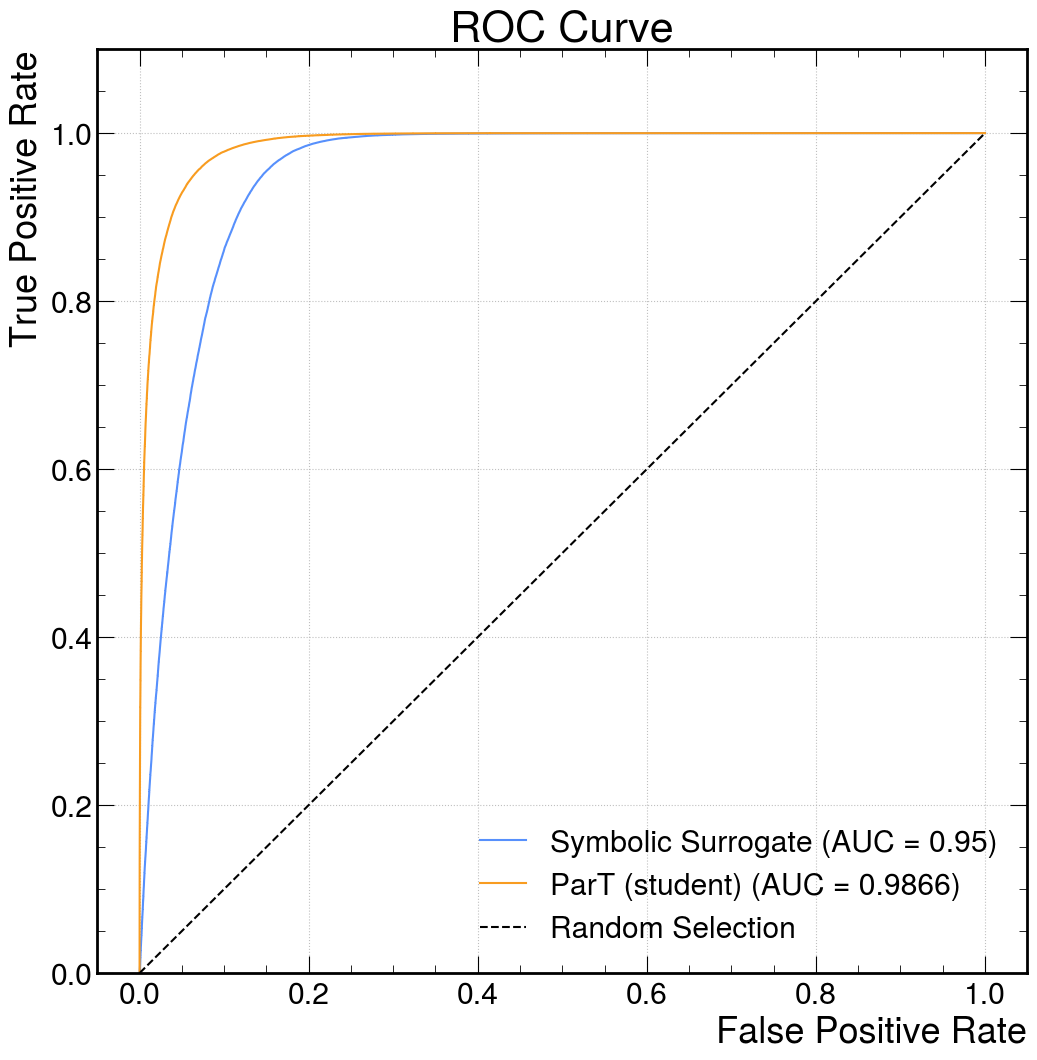

Surrogate Parameters: 142536
Surrogate Parameters (equation): 8
ParT Parameters: 743318
Surrogate:
Background Rejection at 50.0% Signal Efficiency: 28.441410693970422
ParT:
Background Rejection at 50.0% Signal Efficiency: 338.98305084745766


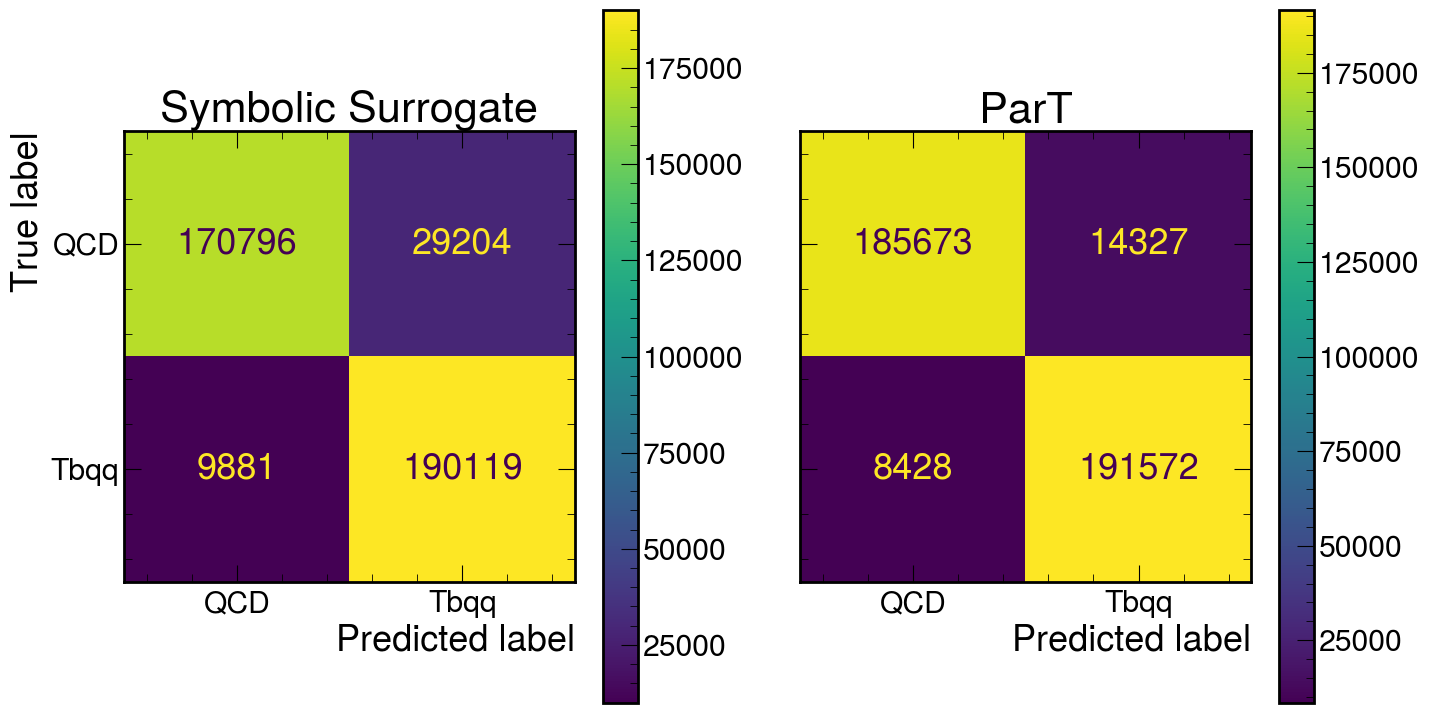

In [53]:
from src.metrics.classification import roc_metrics

fpr_s, tpr_s, auc_s = roc_metrics(labels['_label_'], scores)

print(f'Surrogate AUC: {auc_s:.4f}')

fpr_dl, tpr_dl, auc_dl = roc_metrics(dl_labels['_label_'], dl_scores)

print(f'DL AUC: {auc_dl:.4f}')

print(f'Percentage of Classification Performance Retained: {((auc_s/auc_dl) * 100):.4f}%')

plt.figure(figsize=(12,12))
plt.plot(fpr_s, tpr_s, label=f'Symbolic Surrogate (AUC = {auc_s:.2f})')
plt.plot(fpr_dl, tpr_dl, label=f'ParT (student) (AUC = {auc_dl:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random Selection')

plt.ylim(0, 1.1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

from src.metrics.complexity import total_params

print(f'Surrogate Parameters: {total_params(predictor)[0] - total_params(autoencoder.mod.decoder)[0]}')
print(f'Surrogate Parameters (equation): {total_params(predictor)[0]-total_params(predictor.mod.autoencoder)[0]}')
print(f'ParT Parameters: {total_params(ParT)[0]}')

from src.metrics.classification import bkg_rej

print('Surrogate:')
bkg_rej(labels['_label_'], scores)
print('ParT:')
bkg_rej(dl_labels['_label_'], dl_scores)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_student = confusion_matrix(y_true=labels['_label_'], y_pred = np.round(scores[:, 1]))
cm_part = confusion_matrix(y_true=dl_labels['_label_'], y_pred = np.round(dl_scores[:, 1]))


fig, ax = plt.subplots(1, 2, figsize=(16, 9))
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_student, display_labels=['QCD', 'Tbqq']).plot(ax=ax[0])
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_part, display_labels=['QCD', 'Tbqq']).plot(ax=ax[1])
disp_1.ax_.set_title('Symbolic Surrogate')
disp_2.ax_.set_title('ParT')
disp_2.ax_.set_ylabel('')
disp_2.ax_.tick_params(axis='y', labelleft=False)

plt.show()

In [68]:
for name, param in predictor.mod.signal.named_parameters():
    print(f"Layer Name: {name}")
    print(f"Parameter Data:\n{param.data}\n")

Layer Name: _node._args.0._value
Parameter Data:
-2.2539985179901123

Layer Name: _node._args.1._args.1._args.0._args.0._args.0._args.0._args.1._args.0._value
Parameter Data:
0.4355708658695221

Layer Name: _node._args.1._args.1._args.0._args.0._args.1._args.0._value
Parameter Data:
0.007396189495921135

Layer Name: _node._args.1._args.1._args.1._args.0._value
Parameter Data:
-0.25757625699043274



In [70]:
model.sympy()[1]

-tanh((x3 + (x14 + x22)/0.43557087)/0.0073961895)/(-0.25757626) - 2.2539985